In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import factorial
from scipy.special import eval_genlaguerre
import matplotlib
import csv

In [2]:
q1 = -np.array([0.0,-1.0],dtype = complex)  # lattice vectors in the Q lattice
q2 = -np.array([np.sqrt(3)/2,0.5],dtype = complex)
q3 = -np.array([-np.sqrt(3)/2,0.5],dtype = complex)

b1 = q2 - q1
b2 = q3 - q1

# Lattice vectors
a1 = (2./3)*np.array([-np.sqrt(3)/2,-0.5],dtype = complex)  # lattice vectors in the Q lattice
a2 = (2./3)*np.array([np.sqrt(3)/2,-0.5],dtype = complex)  # lattice vectors in the Q lattice

# special points in the MBZ
kpt = 2*np.pi*q3 # The K point
gpt = 2*np.pi*np.array([0.0,0.0], dtype = complex) # The Gamma point
mpt = 2*np.pi*q3 + 0.5*2*np.pi*q1 # The M point
mmpt = -mpt
kppt = -kpt

# 3 parameters  
w0 = 0.75/np.sqrt(3) # work slightly away from the magic angle
w1 = 0.75/np.sqrt(3)
vFkth = 110.0*np.sqrt(3)

In [3]:
ax1, ay1 = a1
ax2, ay2 = a2
omega = abs(ax1 * ay2 - ay1 * ax2)
    
z1 = (ax1 + 1.0j*ay1)/np.sqrt(omega)
z1bar = (ax1 - 1.0j*ay1)/np.sqrt(omega)
z2 = (ax2 + 1.0j*ay2)/np.sqrt(omega)
z2bar = (ax2 - 1.0j*ay2)/np.sqrt(omega)

In [4]:
formFactors1 = np.zeros((100,100),dtype=complex)
formFactors2 = np.zeros((100,100),dtype=complex)

file1 = open('./TBG_1.csv', 'r')
for j,line in enumerate(file1.readlines()):
    formFactors1[j] = [complex(i.replace('*^','e').replace('*I','j')) for i in line.split(',')]
    
file2 = open('./TBG_2.csv', 'r')
for j,line in enumerate(file2.readlines()):
    formFactors2[j] = [complex(i.replace('*^','e').replace('*I','j')) for i in line.split(',')]

In [12]:
c3phases = np.load('c3phases.npy')

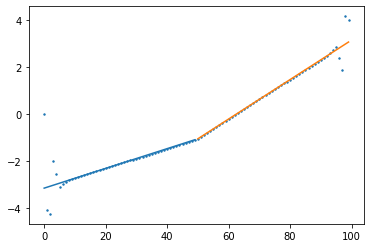

In [16]:
plt.scatter(range(100),0.5*c3phases,s=2)
plt.plot([-np.pi+i/50*2*np.pi/3 for i in range(50)])
plt.plot(range(50,100),[-np.pi/3+(i-50)/50*4*np.pi/3 for i in range(50,100)])

In [17]:
num_landau = 80
energy = np.sqrt((3*np.sqrt(3))/(2*np.pi))
kinetic_1 = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex) # layer 1
kinetic_2 = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex) # layer 2

# First we add the kinetic terms
for m in range(-num_landau,num_landau+1): 
    kinetic_1[m][m] = energy * np.sqrt(abs(m)) *np.sign(m)
    kinetic_2[m][m] = energy * np.sqrt(abs(m)) *np.sign(m)

# And then the shifts from the change of basis    
for m in range(-num_landau,num_landau+1):
    for n in range(-num_landau,num_landau+1):
        if (abs(m)-1 == abs(n)):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            kinetic_2[m][n] = 0.5j*np.sign(m)*coeff
            kinetic_1[m][n] = -0.5j*np.sign(m)*coeff
        elif (abs(m) == abs(n)-1):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            kinetic_2[m][n] = -0.5j*np.sign(n)*coeff
            kinetic_1[m][n] = 0.5j*np.sign(n)*coeff

In [18]:
# now the T-matrices, but the k-dependence is factored out
t1_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
t2_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
t3_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)

for m in range(-num_landau,num_landau+1):
    for n in range(-num_landau,num_landau+1):            
        coe = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            
        t2_matrix[m][n] += coe*w0*formFactors1[abs(m),abs(n)]
        t3_matrix[m][n] += coe*w0*formFactors2[abs(m),abs(n)]
            
        if abs(n) > 0 and abs(m) > 0:
            t2_matrix[m][n] += np.sign(m*n)*coe*w0*formFactors1[abs(m)-1,abs(n)-1]
            t3_matrix[m][n] += np.sign(m*n)*coe*w0*formFactors2[abs(m)-1,abs(n)-1]

        if abs(n) > 0:
            t2_matrix[m][n] += np.sign(n)*coe*w1*np.exp(-2.0j*np.pi/3)*formFactors1[abs(m),abs(n)-1]
            t3_matrix[m][n] += np.sign(n)*coe*w1*np.exp(2.0j*np.pi/3)*formFactors2[abs(m),abs(n)-1]

        if abs(m) > 0:
            t2_matrix[m][n] += np.sign(m)*coe*w1*np.exp(2.0j*np.pi/3)*formFactors1[abs(m)-1,abs(n)]
            t3_matrix[m][n] += np.sign(m)*coe*w1*np.exp(-2.0j*np.pi/3)*formFactors2[abs(m)-1,abs(n)]

        if abs(m) == abs(n):
            t1_matrix[m][n] += w0*coe
            if abs(m) != 0:
                t1_matrix[m][n] += w0*coe*np.sign(m*n)
                    
        if abs(m)-1 == abs(n) and abs(m) != 0:
            t1_matrix[m][n] += w1*coe*np.sign(m)
                
        if abs(n)-1 == abs(m) and abs(n) != 0:
            t1_matrix[m][n] += w1*coe*np.sign(n)

def generateHam(k):
    k1 = np.dot(a1,k)
    k2 = np.dot(a2,k)
    t_mat = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
    t_mat = t1_matrix + np.exp(-1.0j*k2) * t2_matrix + np.exp(1.0j*k1) *t3_matrix
    hamiltonian = np.block([[kinetic_1, t_mat], [t_mat.conj().T, kinetic_2]])
    return(vFkth*hamiltonian)

In [19]:
# create the Z_matrix
num_landau = 80
z1_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
z2_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
zeros = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)

for m in range(-num_landau,num_landau+1):
    for n in range(-num_landau,num_landau+1):
        if (abs(m) == abs(n)+1):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m)))) * 1.0/np.sqrt(4*np.pi)
            z1_matrix[m][n] += z1*(np.sqrt(abs(n) + 1) + np.sign(m*n)*np.sqrt(abs(n)))*coeff
            z2_matrix[m][n] += z2*(np.sqrt(abs(n) + 1) + np.sign(m*n)*np.sqrt(abs(n)))*coeff
            
        elif (abs(m) == abs(n)-1):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m)))) * 1.0/np.sqrt(4*np.pi)
            z1_matrix[m][n] += z1bar*(np.sqrt(abs(n)) + np.sign(m*n)*np.sqrt(abs(n) - 1))*coeff
            z2_matrix[m][n] += z2bar*(np.sqrt(abs(n)) + np.sign(m*n)*np.sqrt(abs(n) - 1))*coeff

z1_total_mat = np.block([[z1_matrix,zeros],[zeros,z1_matrix]])
z2_total_mat = np.block([[z2_matrix,zeros],[zeros,z2_matrix]])

In [20]:
(np.dot(z1_total_mat,z2_total_mat)-np.dot(z2_total_mat,z1_total_mat))[0,0]

0.15915494309189532j

We generate the C3 invariant paths as in Song et al.  Paths are accumulated into path_list

In [22]:
midpoints1 = [2*np.pi*(q1+q2)*(1.-i/50.0) for i in range(50)]
midpoints2 = [2*np.pi*(q3+q2)*i/50.0 for i in range(50)]
midpoints3 = [2*np.pi*(q3+q1)*i/50.0 for i in range(50)]

In [23]:
# generate the C3 invariant paths

path_list=[]
for j in range(50): # first 50 paths
    pt1 = [2*np.pi*q2*(1.-i/50.0) + midpoints1[j]*i/50.0 for i in range(50)]+[midpoints1[j]*(1.-i/50.0) + 2*np.pi*q1*i/50.0 for i in range(50)]
    path_list.append(pt1)
    
for j in range(50): # next 50 paths
    pt1 = [2*np.pi*q2*(1.-i/50.0) + midpoints2[j]*i/50.0 for i in range(50)]+[midpoints2[j]*(1.-i/50.0) + 2*np.pi*q3*i/50.0 for i in range(50)]
    pt2 = [2*np.pi*q3*(1.-i/50.0) + midpoints3[j]*i/50.0 for i in range(50)]+[midpoints3[j]*(1.-i/50.0) + 2*np.pi*q1*i/50.0 for i in range(50)]
    path_list.append(pt1+pt2)

In [24]:
def plotHexagon(points,l1,l2):
    # first, translate the states into the hexagon
    # define the unit vectors that define the hexagon
    dist = np.linalg.norm(l1)
    hex1 = l1/np.linalg.norm(l1)
    hex2 = l2/np.linalg.norm(l2)
    l3 = l2 - l1
    hex3 = l3/np.linalg.norm(l3)
    newPoints = []
    for coords in points:
        len1 = np.dot(coords, hex1)
        len2 = np.dot(coords, hex2)
        len3 = np.dot(coords, hex3)
        if len1 < 0.5*dist+0.00005 and len2 < 0.5*dist+0.00005:
            newPoints.append(coords)
        elif len1 > dist and len2 > dist:
            newPoints.append(coords-l1-l2)
        elif len3 > 0:
            newPoints.append(coords-l2)
        else:
            newPoints.append(coords-l1)
            
    return(np.array(newPoints))

In [25]:
def inHexagon(pointsx,pointsy,l1,l2):
    # first, translate the states into the hexagon
    # define the unit vectors that define the hexagon
    matrixOfVals = np.zeros(np.shape(pointsx))
    dist = np.linalg.norm(l1)
    hex1 = l1/np.linalg.norm(l1)
    hex2 = l2/np.linalg.norm(l2)
    l3 = l2 - l1
    hex3 = l3/np.linalg.norm(l3)
    inside = []
    for i in range(len(pointsx)):
        for j in range(len(pointsx[0])):
            matrixOfVals[i][j] = 0
            coords = np.array([pointsx[i][j],pointsy[i][j]])
            len1 = np.dot(coords, hex1)
            len2 = np.dot(coords, hex2)
            len3 = np.dot(coords, hex3)
            if len1 < 2*np.pi*np.sqrt(3)/2 and len1 > -2*np.pi*np.sqrt(3)/2:
                if len2 < 2*np.pi*np.sqrt(3)/2 and len2 > -2*np.pi*np.sqrt(3)/2:
                    if len3 < 2*np.pi*np.sqrt(3)/2 and len3 > -2*np.pi*np.sqrt(3)/2:
                        matrixOfVals[i][j] = 1.0
    return(matrixOfVals)

In [26]:
query=plotHexagon(path_list[0],2*np.pi*b1,2*np.pi*b2)
query2=plotHexagon(path_list[25],2*np.pi*b1,2*np.pi*b2)
query3=plotHexagon(path_list[49],2*np.pi*b1,2*np.pi*b2)
query4=plotHexagon(path_list[50],2*np.pi*b1,2*np.pi*b2)
query5=plotHexagon(path_list[75],2*np.pi*b1,2*np.pi*b2)
query6=plotHexagon(path_list[99],2*np.pi*b1,2*np.pi*b2)

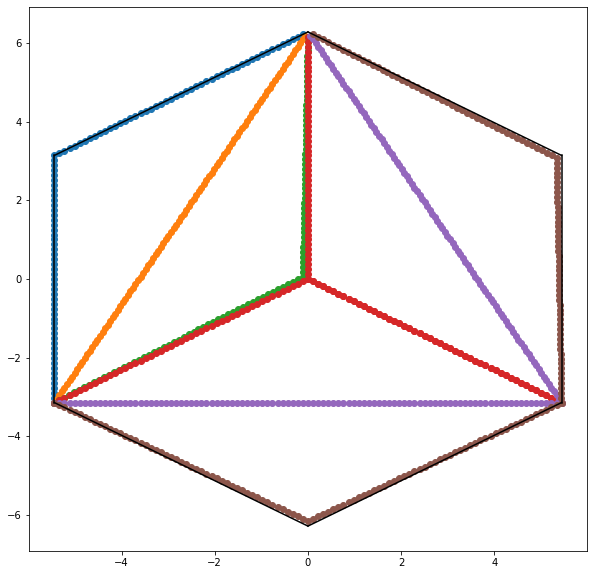

In [27]:
# plots of the C3 invariant paths

plt.figure(figsize=(10,10))

plt.plot([np.real(2*np.pi*q1[0]),np.real(2*np.pi*q1[0]+2*np.pi*q3[0])],[np.real(2*np.pi*q1[1]),np.real(2*np.pi*q1[1]+2*np.pi*q3[1])],c='black')
plt.plot([np.real(2*np.pi*q3[0]),np.real(2*np.pi*q1[0]+2*np.pi*q3[0])],[np.real(2*np.pi*q3[1]),np.real(2*np.pi*q1[1]+2*np.pi*q3[1])],c='black')
plt.plot([np.real(2*np.pi*q3[0]),np.real(2*np.pi*q2[0]+2*np.pi*q3[0])],[np.real(2*np.pi*q3[1]),np.real(2*np.pi*q2[1]+2*np.pi*q3[1])],c='black')
plt.plot([np.real(2*np.pi*q2[0]),np.real(2*np.pi*q2[0]+2*np.pi*q3[0])],[np.real(2*np.pi*q2[1]),np.real(2*np.pi*q2[1]+2*np.pi*q3[1])],c='black')
plt.plot([np.real(2*np.pi*q2[0]),np.real(2*np.pi*q2[0]+2*np.pi*q1[0])],[np.real(2*np.pi*q2[1]),np.real(2*np.pi*q2[1]+2*np.pi*q1[1])],c='black')
plt.plot([np.real(2*np.pi*q1[0]),np.real(2*np.pi*q2[0]+2*np.pi*q1[0])],[np.real(2*np.pi*q1[1]),np.real(2*np.pi*q2[1]+2*np.pi*q1[1])],c='black')

plt.scatter(query[:,0],query[:,1])
plt.scatter(query2[:,0],query2[:,1])
plt.scatter(query3[:,0],query3[:,1])
plt.scatter(query4[:,0],query4[:,1])
plt.scatter(query5[:,0],query5[:,1])
plt.scatter(query6[:,0],query6[:,1])

In [28]:
listOfEigvalsWilson = []

for path in path_list:
    wilsonMatrix = getWilsonSpectrum(path)
    eigval,eigvec = np.linalg.eig(np.matrix(wilsonMatrix))
    listOfEigvalsWilson.append(-1.0j*np.log(eigval))
    
arrayOfEigvalsWilson = np.array(listOfEigvalsWilson)

In [29]:
listOfEigvalsWilson = []

for path in path_list:
    wilsonMatrix = getWilsonSpectrum(path)
    eigval,eigvec = np.linalg.eig(np.matrix(wilsonMatrix))
    listOfEigvalsWilson.append(-1.0j*np.log(eigval))
    
arrayOfEigvalsWilson = np.array(listOfEigvalsWilson)

In [30]:
np.save('./C3_Song.npy', arrayOfEigvalsWilson)

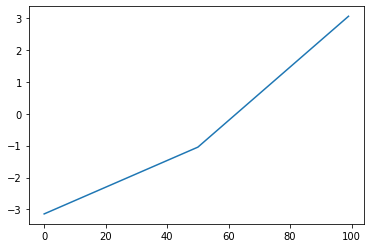

In [31]:
approxPhases = np.array([-np.pi + 2*np.pi/3*i/50 for i in range(50)]+[-np.pi/3 + 4*np.pi/3*(i-50)/50. for i in range(50,100)])
plt.plot(approxPhases) # the Abelian contribution

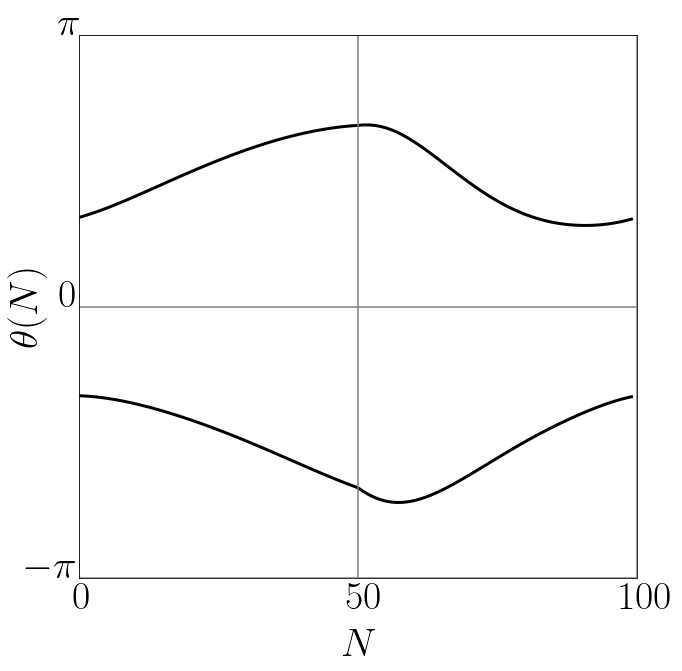

In [32]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import ticker
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 40}
matplotlib.rc('font', **font)
matplotlib.rc('text',usetex=True)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

plt.tick_params(axis = 'x', which = "both", bottom = None, top = None,labelbottom=False)
plt.tick_params(axis = 'y', which = "both", bottom = None, top = None,labelleft=False)

values0=np.mod(np.real(arrayOfEigvalsWilson[:,0]-approxPhases +np.pi),2*np.pi)
values1=np.mod(np.real(arrayOfEigvalsWilson[:,1]-approxPhases +np.pi),2*np.pi)

v0 = np.zeros(100)
v1 = np.zeros(100)

for i in range(100):
    v0[i] = max(values0[i],values1[i])
    v1[i] = min(values0[i],values1[i])


#plt.plot(range(50), values0,c='black',linewidth=4) 
#plt.plot(range(50), values0,c='black',linewidth=4) 

plt.plot(range(100), v0,c='black',linewidth=3) 
plt.plot(range(100), v1,c='black',linewidth=3) 

plt.axhline(y=0,color='gray')
plt.axhline(y=np.pi,color='gray')
plt.axhline(y=2*np.pi,color='gray')

plt.text(-9.75,0,r'$-\pi$',rotation=0)
plt.text(-3.5,np.pi,r'$0$',rotation=0)
plt.text(-3.75,2*np.pi,r'$\pi$',rotation=0)

plt.axvline(x=0,color='gray')
plt.axvline(x=50,color='gray')
plt.axvline(x=100,color='gray')

plt.text(0-1,-0.35,r'$0$',rotation=0)
plt.text(50-2.2,-0.35,r'$50$',rotation=0)
plt.text(100-3,-0.35,r'$100$',rotation=0)
plt.xlim([-0,100])
plt.ylim([0,2*np.pi])

plt.ylabel(r'$\theta(N)$',labelpad=32)
plt.xlabel(r'$N$',labelpad=50)
#ax.set_frame_on(False)
plt.tick_params(left=False)
plt.savefig('Zhida_C3.pdf',bbox_inches='tight')

Now do the Bradlyn symmetric loop

In [36]:
# create hexagonal path

hexstart = [-mmpt*(i/50.0) for i in range(151)]
hexmid1 = [2*np.pi*(q1+q3)*(i/50.0) for i in range(151)]
hexmid2 = [2*np.pi*(q1)*(i/50.0) for i in range(151)]
hexmid3 = [2*np.pi*(q1+q2)*(i/50.0) for i in range(151)]
hexmid4 = [2*np.pi*(q2)*(i/50.0) for i in range(151)]
hexmid5 = [2*np.pi*(q2+q3)*(i/50.0) for i in range(151)]
hexmid6 = [2*np.pi*(q3)*(i/50.0) for i in range(151)]

In [37]:
path_hex_list = []
for i in range(151):
    pt1 = [(hexstart[i]*(1.-j/25.) + hexmid1[i]*(j/25.)) for j in range(25)]
    pt2 = [(hexmid1[i]*(1.-j/50.) + hexmid2[i]*(j/50.)) for j in range(50)]
    pt3 = [(hexmid2[i]*(1.-j/50.) + hexmid3[i]*(j/50.)) for j in range(50)]
    pt4 = [(hexmid3[i]*(1.-j/50.) + hexmid4[i]*(j/50.)) for j in range(50)]
    pt5 = [(hexmid4[i]*(1.-j/50.) + hexmid5[i]*(j/50.)) for j in range(50)]
    pt6 = [(hexmid5[i]*(1.-j/50.) + hexmid6[i]*(j/50.)) for j in range(50)]
    pt7 = [(hexmid6[i]*(1.-j/25.) + hexstart[i]*(j/25.)) for j in range(25)]
    path_hex_list.append(pt1+pt2+pt3+pt4+pt5+pt6+pt7)

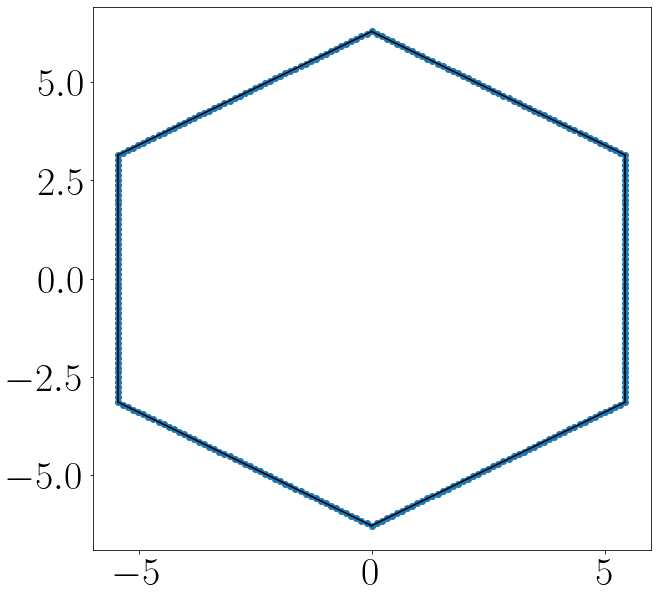

In [49]:
# plots of the C3 invariant paths

plt.figure(figsize=(10,10))

plt.plot([np.real(2*np.pi*q1[0]),2*np.pi*np.real(q1[0]+q3[0])],[2*np.pi*np.real(q1[1]),2*np.pi*np.real(q1[1]+q3[1])],c='black')
plt.plot([np.real(2*np.pi*q3[0]),2*np.pi*np.real(q1[0]+q3[0])],[2*np.pi*np.real(q3[1]),2*np.pi*np.real(q1[1]+q3[1])],c='black')
plt.plot([np.real(2*np.pi*q3[0]),2*np.pi*np.real(q2[0]+q3[0])],[2*np.pi*np.real(q3[1]),2*np.pi*np.real(q2[1]+q3[1])],c='black')
plt.plot([np.real(2*np.pi*q2[0]),2*np.pi*np.real(q2[0]+q3[0])],[2*np.pi*np.real(q2[1]),2*np.pi*np.real(q2[1]+q3[1])],c='black')
plt.plot([np.real(2*np.pi*q2[0]),2*np.pi*np.real(q2[0]+q1[0])],[2*np.pi*np.real(q2[1]),2*np.pi*np.real(q2[1]+q1[1])],c='black')
plt.plot([np.real(2*np.pi*q1[0]),2*np.pi*np.real(q2[0]+q1[0])],[2*np.pi*np.real(q1[1]),2*np.pi*np.real(q2[1]+q1[1])],c='black')

plt.scatter(np.array(path_hex_list)[50,:,0],np.array(path_hex_list)[50,:,1])

In [50]:
listOfEigvalsWilson = []

for path in path_hex_list:
    wilsonMatrix = getWilsonSpectrum(path)
    eigval,eigvec = np.linalg.eig(np.matrix(wilsonMatrix))
    listOfEigvalsWilson.append(-1.0j*np.log(eigval))
    
arrayOfEigvalsWilson = np.array(listOfEigvalsWilson)

In [51]:
np.save('./C3_Bradlyn.npy', arrayOfEigvalsWilson)

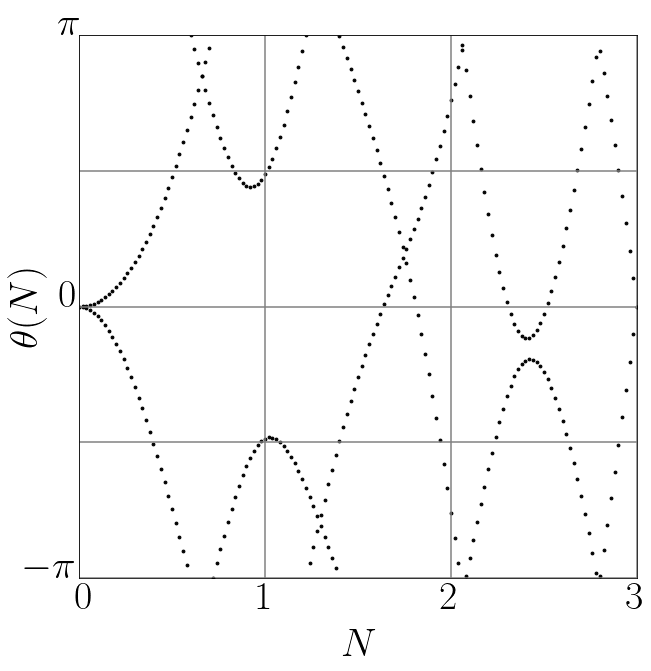

In [53]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 40}
matplotlib.rc('font', **font)
matplotlib.rc('text',usetex=True)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

plt.tick_params(axis = 'x', which = "both", bottom = None, top = None,labelbottom=False)
plt.tick_params(axis = 'y', which = "both", bottom = None, top = None,labelleft=False)

values0=np.mod(np.real(arrayOfEigvalsWilson[:,0] -np.array([2*np.pi*(i/50.0)**2 for i in range(151)])+np.pi),2*np.pi)
values1=np.mod(np.real(arrayOfEigvalsWilson[:,1] -np.array([2*np.pi*(i/50.0)**2 for i in range(151)])+np.pi),2*np.pi)

#plt.plot(range(50), values0,c='black',linewidth=4) 
#plt.plot(range(50), values0,c='black',linewidth=4) 

#plt.plot(range(151)[33:36], v0[33:36],c='black',linewidth=3) 
#plt.plot(range(151)[33:36], v1[33:36],c='black',linewidth=3) 

plt.scatter(range(151), values0,c='black',s=8) 
plt.scatter(range(151), values1,c='black',s=8) 
#plt.plot(range(151)[35:80], v0[35:80],c='black',linewidth=3) 
#plt.plot(range(151)[35:80], v1[35:80],c='black',linewidth=3) 

plt.axhline(y=0,color='gray')
plt.axhline(y=np.pi,color='gray')
plt.axhline(y=2*np.pi,color='gray')
plt.axhline(y=np.pi/2,color='gray')
plt.axhline(y=3*np.pi/2,color='gray')

plt.text(-14.75,0,r'$-\pi$',rotation=0)
plt.text(-5.5,np.pi,r'$0$',rotation=0)
plt.text(-5.75,2*np.pi,r'$\pi$',rotation=0)

plt.axvline(x=0,color='gray')
plt.axvline(x=50,color='gray')
plt.axvline(x=100,color='gray')
plt.axvline(x=150,color='gray')


plt.text(0-1,-0.35,r'$0$',rotation=0)
plt.text(50-2.2,-0.35,r'$1$',rotation=0)
plt.text(100-3,-0.35,r'$2$',rotation=0)
plt.text(150-3,-0.35,r'$3$',rotation=0)

plt.xlim([-0,150])
plt.ylim([0,2*np.pi])

plt.ylabel(r'$\theta(N)$',labelpad=32)
plt.xlabel(r'$N$',labelpad=50)
#ax.set_frame_on(False)
plt.tick_params(left=False)
plt.savefig('Bradlyn_C3.pdf',bbox_inches='tight')